# Poisson MCMC
- runs MCMC for Poisson (Gamma distributed log-likelihood for lambdas) with MH sampling
    - $\lambda_{proposal}$ chosen in random walk  up or down from $\lambda_{current}$ in the space of positive integers
    - step of random walk shortens if acceptance too low, lengthens if acceptance too high
- runs MCMC for Y: IxN time steps and X: JxN time steps
    - One $\lambda$ per time slice and route
- run same for Negative Binomial
    - It is not clear whether I'm already generating negative binomial distributions ?
    - https://statisticalmodeling.wordpress.com/2018/10/25/gamma-distribution-and-poisson-distribution/
    - The std dev of the result is heavily influenced by the result being stuck over long periods, so dispersion is hard to calculate


# Compressive sampling / network tomography workbook
### Implement Dey, et al. toy model from Figure 1
- Subrasankha Dey, Stephen Winter and Martin Tomko, Origin-Destination Flow Estimation from Link Count Data Only, Sensors 2020, 20, 5226.
### Compare output with workbook CompressionSensing_7.ipynb

@article{diamond2016cvxpy,
  author  = {Steven Diamond and Stephen Boyd},
  title   = {{CVXPY}: {A} {P}ython-embedded modeling language for convex optimization},
  journal = {Journal of Machine Learning Research},
  year    = {2016},
  volume  = {17},
  number  = {83},
  pages   = {1--5},
}

# Use final_project environment
-cvxpy
-osmnx
-pytorch
-geopandas

In [1]:
import numpy as np
import cvxpy as cvx
import geopandas as gp
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
import os
import errno
data_dir = "../"
print("Data directory ",data_dir)
path = os.path.join(data_dir,"output")

try:
    os.mkdir(path)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass
print("Created directory "+path)

Data directory  ../
Created directory ../output


# Toy model from Figure 1 in Dey(2020)
- 6 nodes in 3x2 grid
- All are O and D (12 relations)
- 7 directed one-way edges
- Multiple routes per OD relation (16 total)
- Test my implementation of the P matrix

In [3]:
nodes=["A","B","C","D","E","F"]# node names
edges=["AB","AD","DE","EF","BC","BE","CF"]#edge names
edge_uv=[("A","B"),("A","D"),("D","E"),("E","F"),("B","C"),("B","E"),("C","F")]# node names u,v
edge_weights=[1,1,1,1,1,1,1]
edge_weights_dict=dict(zip(edge_uv,edge_weights))
edge_labels_dict = dict(zip(edges, edge_uv))
node_xy=[(0,0),(1,0),(2,0),(0,1),(1,1),(2,1)]
node_xy_dict=dict(zip(nodes,node_xy))

In [4]:
edge_weights_dict

{('A', 'B'): 1,
 ('A', 'D'): 1,
 ('D', 'E'): 1,
 ('E', 'F'): 1,
 ('B', 'C'): 1,
 ('B', 'E'): 1,
 ('C', 'F'): 1}

In [5]:
edge_labels_dict

{'AB': ('A', 'B'),
 'AD': ('A', 'D'),
 'DE': ('D', 'E'),
 'EF': ('E', 'F'),
 'BC': ('B', 'C'),
 'BE': ('B', 'E'),
 'CF': ('C', 'F')}

In [6]:
node_xy_dict

{'A': (0, 0), 'B': (1, 0), 'C': (2, 0), 'D': (0, 1), 'E': (1, 1), 'F': (2, 1)}

# Make a networkx object of the graph

In [7]:
G=nx.DiGraph()
G.graph["name"]="Model 1 Hazelton(2015)"
G.add_nodes_from(nodes)
nx.set_node_attributes(G,node_xy_dict,name="pos")
G.add_edges_from(edge_uv)#add_weighted_edges_from (3,1,5.493) tuple u,v,weight
nx.set_edge_attributes(G,edge_weights_dict,name="weight")
print(G.number_of_nodes(), G.number_of_edges())
print(list(G.nodes))
print(list(G.edges))
#G.adj.items#
#G.edges.data# for (u, v, wt) in FG.edges.data('weight'):
print(list(G.neighbors("A")))

6 7
['A', 'B', 'C', 'D', 'E', 'F']
[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'F'), ('D', 'E'), ('E', 'F')]
['B', 'D']


In [8]:
print(nx.get_node_attributes(G,"pos"))

{'A': (0, 0), 'B': (1, 0), 'C': (2, 0), 'D': (0, 1), 'E': (1, 1), 'F': (2, 1)}


In [9]:
print(nx.get_edge_attributes(G,"weight"))

{('A', 'B'): 1, ('A', 'D'): 1, ('B', 'C'): 1, ('B', 'E'): 1, ('C', 'F'): 1, ('D', 'E'): 1, ('E', 'F'): 1}


In [10]:
list(nx.all_simple_paths(G,"A","D"))

[['A', 'D']]

# Plot only shows weights of one link if links are parallel
- for better plots use graphvis or ox

{('A', 'B'): Text(0.5, 0.0, '1'),
 ('A', 'D'): Text(0.0, 0.5, '1'),
 ('B', 'C'): Text(1.5, 0.0, '1'),
 ('B', 'E'): Text(1.0, 0.5, '1'),
 ('C', 'F'): Text(2.0, 0.5, '1'),
 ('D', 'E'): Text(0.5, 1.0, '1'),
 ('E', 'F'): Text(1.5, 1.0, '1')}

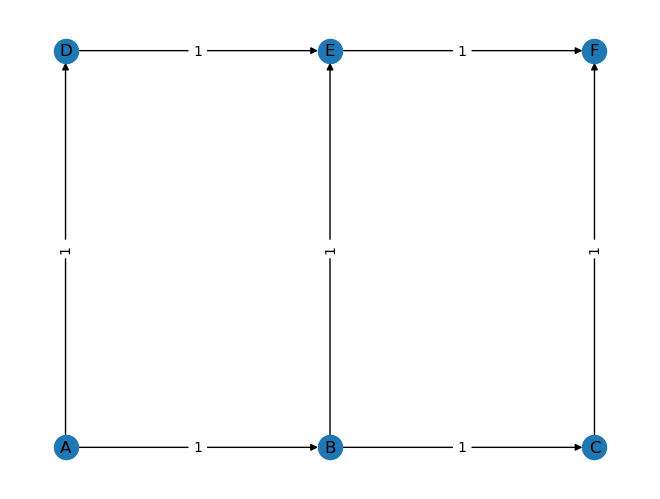

In [11]:
pos=nx.get_node_attributes(G,"pos")
nx.draw(G,pos,with_labels=True)
labels = nx.get_edge_attributes(G,"weight")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
#subax2=plt.subplot(122)
#nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')


# $Y_i$

In [12]:
counts=np.zeros((7,5))# rows are links with counts, columns are counts in a time interval
counts[0,:]=[255,190,220,190,235]# edge 1
counts[1,:]=[85,78,80,77,79]# no counts for edge 2
counts[2,:]=[235,181,186,176,195]# edge 3
counts[3,:]=[210,165,180,175,190]# edge 4
counts[4,:]=[56,42,48,56,58]# edge 5
counts[5,:]=[78,74,87,80,83]# edge 6
counts[6,:]=[78,74,87,80,83]# edge 7
countkeys=edge_labels_dict.values()
counts_dict=dict(zip(countkeys,counts[:,:]))

In [13]:
print(countkeys)

dict_values([('A', 'B'), ('A', 'D'), ('D', 'E'), ('E', 'F'), ('B', 'C'), ('B', 'E'), ('C', 'F')])


In [14]:
counts_dict

{('A', 'B'): array([255., 190., 220., 190., 235.]),
 ('A', 'D'): array([85., 78., 80., 77., 79.]),
 ('D', 'E'): array([235., 181., 186., 176., 195.]),
 ('E', 'F'): array([210., 165., 180., 175., 190.]),
 ('B', 'C'): array([56., 42., 48., 56., 58.]),
 ('B', 'E'): array([78., 74., 87., 80., 83.]),
 ('C', 'F'): array([78., 74., 87., 80., 83.])}

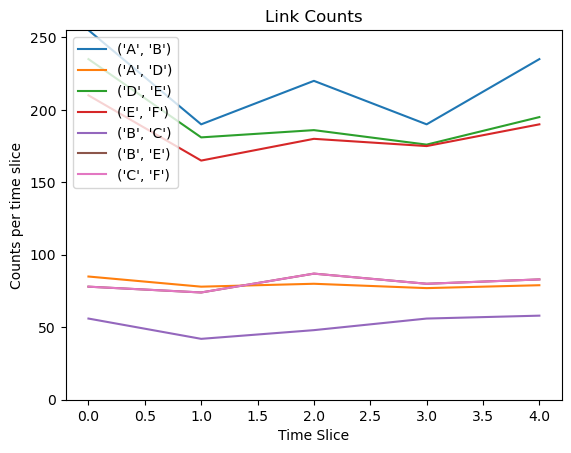

In [15]:
import matplotlib.pyplot as plt
x=list(range(0,counts.shape[1]))
for ii in range(counts.shape[0]):
    plt.plot(x,counts[ii,:],label=str(list(counts_dict.keys())[ii]))
plt.ylim(0,np.max(counts))
plt.xlabel("Time Slice")
plt.ylabel("Counts per time slice")
plt.legend()
plt.title("Link Counts")
plt.show()

# Routes between O's and D's.
- one list of routes as edge sequences
- one list of routes as node sequences
- note that a dict of OD_pairs to routes must accomodate several routes per OD_pair later on
    - the "zip" can be replaced by an iterator over OD_Pairs, add a list of routes to the OD_Pair key

# $O, D$

In [16]:
origins=nodes
destinations=nodes
od_pairs=[]
for o in origins:
   for d in nx.dfs_postorder_nodes(G,source=o):
    if(o!=d):
        od_pairs.append((o,d))
print(od_pairs)
print(len(od_pairs))

[('A', 'F'), ('A', 'C'), ('A', 'E'), ('A', 'B'), ('A', 'D'), ('B', 'F'), ('B', 'C'), ('B', 'E'), ('C', 'F'), ('D', 'F'), ('D', 'E'), ('E', 'F')]
12


In [17]:
od_route_n_dict={}
od_route_e_dict={}

In [18]:
# routes as sequence of nodes
routes_n=[]
routes_e=[]
for od in od_pairs:
    rnlist=list(nx.all_simple_paths(G,od[0],od[1]))
    od_route_n_dict[od]=rnlist
    routes_n.append(rnlist)
    relist=list(nx.all_simple_edge_paths(G,od[0],od[1]))
    od_route_e_dict[od]=relist
    routes_e.append(relist)

In [19]:
len(routes_e)

12

In [20]:
od_route_n_dict

{('A', 'F'): [['A', 'B', 'C', 'F'],
  ['A', 'B', 'E', 'F'],
  ['A', 'D', 'E', 'F']],
 ('A', 'C'): [['A', 'B', 'C']],
 ('A', 'E'): [['A', 'B', 'E'], ['A', 'D', 'E']],
 ('A', 'B'): [['A', 'B']],
 ('A', 'D'): [['A', 'D']],
 ('B', 'F'): [['B', 'C', 'F'], ['B', 'E', 'F']],
 ('B', 'C'): [['B', 'C']],
 ('B', 'E'): [['B', 'E']],
 ('C', 'F'): [['C', 'F']],
 ('D', 'F'): [['D', 'E', 'F']],
 ('D', 'E'): [['D', 'E']],
 ('E', 'F'): [['E', 'F']]}

In [21]:
od_route_e_dict

{('A', 'F'): [[('A', 'B'), ('B', 'C'), ('C', 'F')],
  [('A', 'B'), ('B', 'E'), ('E', 'F')],
  [('A', 'D'), ('D', 'E'), ('E', 'F')]],
 ('A', 'C'): [[('A', 'B'), ('B', 'C')]],
 ('A', 'E'): [[('A', 'B'), ('B', 'E')], [('A', 'D'), ('D', 'E')]],
 ('A', 'B'): [[('A', 'B')]],
 ('A', 'D'): [[('A', 'D')]],
 ('B', 'F'): [[('B', 'C'), ('C', 'F')], [('B', 'E'), ('E', 'F')]],
 ('B', 'C'): [[('B', 'C')]],
 ('B', 'E'): [[('B', 'E')]],
 ('C', 'F'): [[('C', 'F')]],
 ('D', 'F'): [[('D', 'E'), ('E', 'F')]],
 ('D', 'E'): [[('D', 'E')]],
 ('E', 'F'): [[('E', 'F')]]}

In [22]:
od_route_names_dict={}
route_names=[]
for od in od_pairs:
    od_route_names=[]
    for i in range(0,len(od_route_n_dict[od])):
        string=((od[0],od[1],str(i)))
        od_route_names.append(string)
        route_names.append(string)
    od_route_names_dict[od]=tuple(od_route_names)


In [23]:
route_names

[('A', 'F', '0'),
 ('A', 'F', '1'),
 ('A', 'F', '2'),
 ('A', 'C', '0'),
 ('A', 'E', '0'),
 ('A', 'E', '1'),
 ('A', 'B', '0'),
 ('A', 'D', '0'),
 ('B', 'F', '0'),
 ('B', 'F', '1'),
 ('B', 'C', '0'),
 ('B', 'E', '0'),
 ('C', 'F', '0'),
 ('D', 'F', '0'),
 ('D', 'E', '0'),
 ('E', 'F', '0')]

In [24]:
len(route_names)

16

In [25]:
od_route_names_dict

{('A', 'F'): (('A', 'F', '0'), ('A', 'F', '1'), ('A', 'F', '2')),
 ('A', 'C'): (('A', 'C', '0'),),
 ('A', 'E'): (('A', 'E', '0'), ('A', 'E', '1')),
 ('A', 'B'): (('A', 'B', '0'),),
 ('A', 'D'): (('A', 'D', '0'),),
 ('B', 'F'): (('B', 'F', '0'), ('B', 'F', '1')),
 ('B', 'C'): (('B', 'C', '0'),),
 ('B', 'E'): (('B', 'E', '0'),),
 ('C', 'F'): (('C', 'F', '0'),),
 ('D', 'F'): (('D', 'F', '0'),),
 ('D', 'E'): (('D', 'E', '0'),),
 ('E', 'F'): (('E', 'F', '0'),)}

### Have to flatten the routes_e and routes_n lists in order to assign them to route_names

In [26]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [27]:
print(len(flatten(routes_e)))

16


In [28]:
# dict of origins and routes
routes_e_dict=dict(zip(route_names,flatten(routes_e)))# route names, edge sequence (tuple u,v)
routes_n_dict=dict(zip(route_names,flatten(routes_n)))# route names, node sequence (u)

In [29]:
routes_e_dict

{('A', 'F', '0'): [('A', 'B'), ('B', 'C'), ('C', 'F')],
 ('A', 'F', '1'): [('A', 'B'), ('B', 'E'), ('E', 'F')],
 ('A', 'F', '2'): [('A', 'D'), ('D', 'E'), ('E', 'F')],
 ('A', 'C', '0'): [('A', 'B'), ('B', 'C')],
 ('A', 'E', '0'): [('A', 'B'), ('B', 'E')],
 ('A', 'E', '1'): [('A', 'D'), ('D', 'E')],
 ('A', 'B', '0'): [('A', 'B')],
 ('A', 'D', '0'): [('A', 'D')],
 ('B', 'F', '0'): [('B', 'C'), ('C', 'F')],
 ('B', 'F', '1'): [('B', 'E'), ('E', 'F')],
 ('B', 'C', '0'): [('B', 'C')],
 ('B', 'E', '0'): [('B', 'E')],
 ('C', 'F', '0'): [('C', 'F')],
 ('D', 'F', '0'): [('D', 'E'), ('E', 'F')],
 ('D', 'E', '0'): [('D', 'E')],
 ('E', 'F', '0'): [('E', 'F')]}

In [30]:
routes_n_dict

{('A', 'F', '0'): ['A', 'B', 'C', 'F'],
 ('A', 'F', '1'): ['A', 'B', 'E', 'F'],
 ('A', 'F', '2'): ['A', 'D', 'E', 'F'],
 ('A', 'C', '0'): ['A', 'B', 'C'],
 ('A', 'E', '0'): ['A', 'B', 'E'],
 ('A', 'E', '1'): ['A', 'D', 'E'],
 ('A', 'B', '0'): ['A', 'B'],
 ('A', 'D', '0'): ['A', 'D'],
 ('B', 'F', '0'): ['B', 'C', 'F'],
 ('B', 'F', '1'): ['B', 'E', 'F'],
 ('B', 'C', '0'): ['B', 'C'],
 ('B', 'E', '0'): ['B', 'E'],
 ('C', 'F', '0'): ['C', 'F'],
 ('D', 'F', '0'): ['D', 'E', 'F'],
 ('D', 'E', '0'): ['D', 'E'],
 ('E', 'F', '0'): ['E', 'F']}

In [31]:
edge_labels_dict

{'AB': ('A', 'B'),
 'AD': ('A', 'D'),
 'DE': ('D', 'E'),
 'EF': ('E', 'F'),
 'BC': ('B', 'C'),
 'BE': ('B', 'E'),
 'CF': ('C', 'F')}

In [32]:
# route costs
routes_c_dict={}
for rn in route_names:
    es=routes_e_dict[rn]
    lc=[]
    for e in es:
        c=edge_weights_dict[e]
        lc.append(c)
    routes_c_dict[rn]=lc
print(routes_c_dict)

{('A', 'F', '0'): [1, 1, 1], ('A', 'F', '1'): [1, 1, 1], ('A', 'F', '2'): [1, 1, 1], ('A', 'C', '0'): [1, 1], ('A', 'E', '0'): [1, 1], ('A', 'E', '1'): [1, 1], ('A', 'B', '0'): [1], ('A', 'D', '0'): [1], ('B', 'F', '0'): [1, 1], ('B', 'F', '1'): [1, 1], ('B', 'C', '0'): [1], ('B', 'E', '0'): [1], ('C', 'F', '0'): [1], ('D', 'F', '0'): [1, 1], ('D', 'E', '0'): [1], ('E', 'F', '0'): [1]}


# Adjacency matrix (link-path incidence matrix) A=aij
- counted edges/links versus routes they are on
- 0,1 definition used by Vardi(1996) and Hazelton(2015)
- Make into a function
- This should be OD relations to the right and not routes
    - if there are more than 1 routes per OD relation this code has to be fixed, see later on
- It's still a valuable mapping to have

In [33]:
# a_ij = 1 if link i is in route j, 0 otherwise
I=len(counts_dict)#7
J=len(routes_e)#16
aij=np.zeros((I, J))
for i in range(I):
    for j in range(J):
        for k in range(len(routes_e[j])):
            print(routes_e[j][k])
            print(list(counts_dict.keys())[i])
            if(routes_e[j][k]==list(counts_dict.keys())[i]):
                aij[i,j]=1

[('A', 'B'), ('B', 'C'), ('C', 'F')]
('A', 'B')
[('A', 'B'), ('B', 'E'), ('E', 'F')]
('A', 'B')
[('A', 'D'), ('D', 'E'), ('E', 'F')]
('A', 'B')
[('A', 'B'), ('B', 'C')]
('A', 'B')
[('A', 'B'), ('B', 'E')]
('A', 'B')
[('A', 'D'), ('D', 'E')]
('A', 'B')
[('A', 'B')]
('A', 'B')
[('A', 'D')]
('A', 'B')
[('B', 'C'), ('C', 'F')]
('A', 'B')
[('B', 'E'), ('E', 'F')]
('A', 'B')
[('B', 'C')]
('A', 'B')
[('B', 'E')]
('A', 'B')
[('C', 'F')]
('A', 'B')
[('D', 'E'), ('E', 'F')]
('A', 'B')
[('D', 'E')]
('A', 'B')
[('E', 'F')]
('A', 'B')
[('A', 'B'), ('B', 'C'), ('C', 'F')]
('A', 'D')
[('A', 'B'), ('B', 'E'), ('E', 'F')]
('A', 'D')
[('A', 'D'), ('D', 'E'), ('E', 'F')]
('A', 'D')
[('A', 'B'), ('B', 'C')]
('A', 'D')
[('A', 'B'), ('B', 'E')]
('A', 'D')
[('A', 'D'), ('D', 'E')]
('A', 'D')
[('A', 'B')]
('A', 'D')
[('A', 'D')]
('A', 'D')
[('B', 'C'), ('C', 'F')]
('A', 'D')
[('B', 'E'), ('E', 'F')]
('A', 'D')
[('B', 'C')]
('A', 'D')
[('B', 'E')]
('A', 'D')
[('C', 'F')]
('A', 'D')
[('D', 'E'), ('E', 'F')]
('A

In [34]:
I=len(countkeys)
J=len(route_names)
aij=np.zeros((I,J))
i=0
for e in countkeys:#I
    j=0
    for rn in route_names:#J
        rs=routes_e_dict[rn]
        for r in rs:
#            print(i,j,e,r)
            if(e == r):
                aij[i,j]=1
        j+=1
    i+=1
        

In [35]:
aij# each column is a route between an OD pair J and each row has 1 if a link I is on the route

array([[1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]])

# Matrix of all edges which are on routes a2ij
- Map of all edges/links and the routes they are on
- 0,1
- Use to calculate the flows on non-measured links along the routes
- After the OD flows are calculated

In [36]:
edge_labels_dict.values()

dict_values([('A', 'B'), ('A', 'D'), ('D', 'E'), ('E', 'F'), ('B', 'C'), ('B', 'E'), ('C', 'F')])

In [37]:
I=len(edge_labels_dict.keys())
J=len(route_names)
a2ij=np.zeros((I,J))
pi1=np.zeros((I,J))
i=0
for e in edge_labels_dict.values():#I
    j=0
    for rn in route_names:#J
        rs=routes_e_dict[rn]
        for r in rs:
#            print(i,j,e,r)
            if(e == r):
                a2ij[i,j]=1
                pi1[i,j]=edge_weights[i]
        j+=1
    i+=1

In [38]:
a2ij

array([[1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]])

### For each time slice, Y is counts (dim m x 1) = A (dim m x n) * X (dim n x 1), m<n .
- Need to find X the OD flow
- m is the number of edges with counts on them
- n is the number of routes between OD
- dimension 1 becomes K for K time slices

In [39]:
print(aij.shape, counts.shape)

(7, 16) (7, 5)


# Model 5 days of made-up data on 7 (all links) measured links for all 16 routes (each OD pair has different number of routes). Flows are per route, not per OD

- Hazelton (2015) must use a survey of OD traffic to generate initial x flows using a Gamma function of parameters (x_survey/2, 1/2). How does he use these in the solution?

- The following is solved using ECOS_BB in the package cvxpy

### We need integer-value results and use a special included mixed-integer solver

In [40]:
# y = Ax
# We have y and A and want x
# y is m x 1; A is m x n; x is n x 1; m = 5, n = 6
x = cvx.Variable((aij.shape[1],counts.shape[1]),integer=True)

#err = cvx.abs(aij @ x - counts)
err = cvx.sum_squares(aij @ x - counts)
objective = cvx.Minimize(cvx.norm(err,1))# regularize later with sum(w*aij) see Kurzhanskiy
constraints = [x >= 0 ]
prob = cvx.Problem(objective, constraints)

# The optimal objective is returned by prob.solve().
result = prob.solve(solver="ECOS_BB")

# The optimal value for x is stored in x.value.
print("The flows on the routes (one route per row) in the time slices (one time slice per column)")
print(x.value)

The flows on the routes (one route per row) in the time slices (one time slice per column)
[[9.85903026e-11 9.00000000e+00 1.00000000e+01 1.10000000e+01
  1.20000000e+01]
 [1.50000000e+01 1.40000000e+01 1.60000000e+01 1.40000000e+01
  1.50000000e+01]
 [2.00000000e+01 1.70000000e+01 1.80000000e+01 1.70000000e+01
  1.80000000e+01]
 [1.90000000e+01 1.00000000e+01 1.20000000e+01 1.40000000e+01
  1.50000000e+01]
 [2.00000000e+01 1.90000000e+01 2.20000000e+01 2.00000000e+01
  2.10000000e+01]
 [2.80000000e+01 2.50000000e+01 2.60000000e+01 2.50000000e+01
  2.60000000e+01]
 [2.01000000e+02 1.38000000e+02 1.61000000e+02 1.30000000e+02
  1.73000000e+02]
 [3.70000000e+01 3.50000000e+01 3.60000000e+01 3.50000000e+01
  3.50000000e+01]
 [1.60000000e+01 1.00000000e+01 1.20000000e+01 1.30000000e+01
  1.40000000e+01]
 [1.80000000e+01 1.70000000e+01 2.00000000e+01 1.90000000e+01
  2.00000000e+01]
 [2.10000000e+01 1.30000000e+01 1.40000000e+01 1.80000000e+01
  1.80000000e+01]
 [2.40000000e+01 2.40000000e+

c:\Users\jkhac\anaconda3\envs\final_proj_torch\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [41]:
x.value.shape

(16, 5)

In [42]:
print(np.mean(x.value,axis=1))

[  8.4  14.8  18.   14.   20.4  26.  160.6  35.6  13.   18.8  16.8  26.2
  59.2  43.4 107.   89. ]


In [43]:
print(x.value[4,:])

[20. 19. 22. 20. 21.]


In [44]:
print(f"{np.array2string(np.mean(x.value,axis=1),precision=1, floatmode='fixed')}")
print(f"{np.array2string(np.std(x.value,axis=1),precision=1, floatmode='fixed')}")
print(np.sum(np.mean(x.value,axis=1)))

[  8.4  14.8  18.0  14.0  20.4  26.0 160.6  35.6  13.0  18.8  16.8  26.2
  59.2  43.4 107.0  89.0]
[ 4.3  0.7  1.1  3.0  1.0  1.1 25.4  0.8  2.0  1.2  2.9  1.9  3.8  5.1
 14.1  8.9]
671.2000000000274


In [45]:
# Make OD flows out of the route flows by summing over route flows for each OD

def od_flow_from_route_flow(od_pairs, route_flows):
    
 # Make OD flows out of the route flows by summing over route flows for each OD
    I=x.value.shape[1]
    J=len(od_pairs)
    j=0
    i_r=0
    od_flow=np.zeros((I))
    od_flow_matrix=np.zeros((J,I))
    for od in od_pairs:
        od_flow=0
        rs=od_route_names_dict[od]
        for r in rs:
            od_flow=od_flow+route_flows[i_r,:]
            print(j,i_r,r,od_flow, route_flows[i_r,:])
            i_r+=1
        od_flow_matrix[j,:]=od_flow
        j+=1
    return(od_flow_matrix)

In [46]:
od_flow_matrix_x=od_flow_from_route_flow(od_pairs,x.value)

0 0 ('A', 'F', '0') [9.85903026e-11 9.00000000e+00 1.00000000e+01 1.10000000e+01
 1.20000000e+01] [9.85903026e-11 9.00000000e+00 1.00000000e+01 1.10000000e+01
 1.20000000e+01]
0 1 ('A', 'F', '1') [15. 23. 26. 25. 27.] [15. 14. 16. 14. 15.]
0 2 ('A', 'F', '2') [35. 40. 44. 42. 45.] [20. 17. 18. 17. 18.]
1 3 ('A', 'C', '0') [19. 10. 12. 14. 15.] [19. 10. 12. 14. 15.]
2 4 ('A', 'E', '0') [20. 19. 22. 20. 21.] [20. 19. 22. 20. 21.]
2 5 ('A', 'E', '1') [48. 44. 48. 45. 47.] [28. 25. 26. 25. 26.]
3 6 ('A', 'B', '0') [201. 138. 161. 130. 173.] [201. 138. 161. 130. 173.]
4 7 ('A', 'D', '0') [37. 35. 36. 35. 35.] [37. 35. 36. 35. 35.]
5 8 ('B', 'F', '0') [16. 10. 12. 13. 14.] [16. 10. 12. 13. 14.]
5 9 ('B', 'F', '1') [34. 27. 32. 32. 34.] [18. 17. 20. 19. 20.]
6 10 ('B', 'C', '0') [21. 13. 14. 18. 18.] [21. 13. 14. 18. 18.]
7 11 ('B', 'E', '0') [24. 24. 29. 27. 27.] [24. 24. 29. 27. 27.]
8 12 ('C', 'F', '0') [62. 55. 65. 56. 58.] [62. 55. 65. 56. 58.]
9 13 ('D', 'F', '0') [53. 39. 41. 40. 44.] 

In [47]:
print(f"{np.array2string(np.mean(od_flow_matrix_x,axis=1),precision=1, floatmode='fixed')}")
print(f"{np.array2string(np.std(od_flow_matrix_x,axis=1),precision=1, floatmode='fixed')}")
print(np.sum(np.mean(x.value,axis=1)))

[ 41.2  14.0  46.4 160.6  35.6  31.8  16.8  26.2  59.2  43.4 107.0  89.0]
[ 3.5  3.0  1.6 25.4  0.8  2.6  2.9  1.9  3.8  5.1 14.1  8.9]
671.2000000000274


In [48]:
od_flow_matrix_x=od_flow_from_route_flow(od_pairs,x.value)
print(od_flow_matrix_x)

0 0 ('A', 'F', '0') [9.85903026e-11 9.00000000e+00 1.00000000e+01 1.10000000e+01
 1.20000000e+01] [9.85903026e-11 9.00000000e+00 1.00000000e+01 1.10000000e+01
 1.20000000e+01]
0 1 ('A', 'F', '1') [15. 23. 26. 25. 27.] [15. 14. 16. 14. 15.]
0 2 ('A', 'F', '2') [35. 40. 44. 42. 45.] [20. 17. 18. 17. 18.]
1 3 ('A', 'C', '0') [19. 10. 12. 14. 15.] [19. 10. 12. 14. 15.]
2 4 ('A', 'E', '0') [20. 19. 22. 20. 21.] [20. 19. 22. 20. 21.]
2 5 ('A', 'E', '1') [48. 44. 48. 45. 47.] [28. 25. 26. 25. 26.]
3 6 ('A', 'B', '0') [201. 138. 161. 130. 173.] [201. 138. 161. 130. 173.]
4 7 ('A', 'D', '0') [37. 35. 36. 35. 35.] [37. 35. 36. 35. 35.]
5 8 ('B', 'F', '0') [16. 10. 12. 13. 14.] [16. 10. 12. 13. 14.]
5 9 ('B', 'F', '1') [34. 27. 32. 32. 34.] [18. 17. 20. 19. 20.]
6 10 ('B', 'C', '0') [21. 13. 14. 18. 18.] [21. 13. 14. 18. 18.]
7 11 ('B', 'E', '0') [24. 24. 29. 27. 27.] [24. 24. 29. 27. 27.]
8 12 ('C', 'F', '0') [62. 55. 65. 56. 58.] [62. 55. 65. 56. 58.]
9 13 ('D', 'F', '0') [53. 39. 41. 40. 44.] 

In [49]:
print("The flows on each edge (one edge per row) (one time slice per column")
print("NOTE that all flows equal counts and that edge 5 flows have been imputed by the algorithm")
np.dot(a2ij,x.value)

The flows on each edge (one edge per row) (one time slice per column
NOTE that all flows equal counts and that edge 5 flows have been imputed by the algorithm


array([[255., 190., 221., 189., 236.],
       [ 85.,  77.,  80.,  77.,  79.],
       [235., 180., 186., 176., 195.],
       [210., 165., 180., 175., 190.],
       [ 56.,  42.,  48.,  56.,  59.],
       [ 77.,  74.,  87.,  80.,  83.],
       [ 78.,  74.,  87.,  80.,  84.]])

# MCMC Sampling for Dummies
- https://twiecki.io/blog/2015/11/10/mcmc-sampling/
- also uses pymc3 which i can't get to run due to theano conflicts/not found

# https://github.com/fonnesbeck/scientific-python-workshop/blob/master/notebooks/MCMC.ipynb


### counts is (edges, time)

In [50]:
#Y=counts[:,0]
Y=counts

In [51]:
Y.shape

(7, 5)

### joint log-posterior conditional on parameter values

$yhat_i=aij*\lambda_j$<br>
$p_i=N(yhat_i,t)$


### posterior distribution for a single time slice

In [52]:
from scipy.stats import distributions

dgamma = distributions.gamma.logpdf
dnorm = distributions.norm.logpdf
a= .1#1. rate of occurrences (successes)
b= 10#10 number of poisson distributions in the gamma

def calc_posterior(lam, y=Y, A=aij):
    # Y I x 1
    # aij I x J
    # lam J x 1
    b=len(lam)
    # Calculate joint posterior, given values for lambda (this is the average of X)
    # The gamma pdf gives a likelihood for a Poisson distributed parameter of
    # rate a (lambda) and number of Poisson distributions b
    logp = dgamma(lam, lam,b)
    #print(f"calc_posterior lam {lam}")
    yhat = A @ lam
    # Data likelihood. How appropriate is Std Dev 1?
    #print(f"calc_posterior yhat {yhat.shape} Y {Y.shape} lam {lam.shape}")
    #print(f"calc_posterior yhat {yhat}")
    logp += sum(dnorm(Y, yhat, 1.))
    logp=logp.sum()
    
    return logp

### posterior distribution with any time slice (pass index)

In [53]:
from scipy.stats import distributions

dgamma = distributions.gamma.logpdf
dnorm = distributions.norm.logpdf
a= .1#1. rate of occurrences (successes)
b= 10#10 number of poisson distributions in the gamma

def calc_posterior_t(lam, time_step, y=Y, A=aij):
    # Y I x 1
    # aij I x J
    # lam J x 1
    b=len(lam)
    # Calculate joint posterior, given values for lambda (this is the average of X)
    # The gamma pdf gives a likelihood for a Poisson distributed parameter of
    # rate a (lambda) and number of Poisson distributions b
    logp = dgamma(lam, lam,b)
    #print(f"calc_posterior lam {lam}")
    yhat = A @ lam
    # Data likelihood. How appropriate is Std Dev 1?
    #print(f"calc_posterior yhat {yhat.shape} Y {Y.shape} lam {lam.shape}")
    logp += sum(dnorm(Y[:,time_step], yhat, 1.))
    logp=logp.sum()
    
    return logp

### Acceptance step of Metropolis-Hastings is tuned here

In [54]:
from scipy.stats import poisson

rnorm=np.random.normal
runif = np.random.rand

def metropolis_tuned(n_iterations, initial_values, prop_var=1, 
                     tune_for=None, tune_interval=100):
    
    n_params = len(initial_values)
    #n_params = initial_values.shape[1]# one time step
            
    # Initial proposal standard deviations
    prop_sd = [prop_var] * n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0,:] = initial_values# iteration, route flows
    # Initialize acceptance counts
    accepted = [0]*n_params
    
    # Calculate joint posterior for initial values
    #current_log_prob = calc_posterior(*trace[0])
#    print(f"MH current lambda {trace[0]}")
    current_log_prob = calc_posterior(trace[0,:])
#    print(f"MH current_lp {current_log_prob}")
    if (tune_for > n_iterations):
        print("WARNING: set tune_for < n_iterations or the output arrays will be empty")
    if tune_for is None:
        tune_for = n_iterations/2
    
    for i in range(n_iterations):
    
        if not i%1000: print('Iteration %i' % i)
    
        # Grab current parameter values
        current_params = trace[i,:]
        param_index=np.arange(n_params)
        np.random.shuffle(param_index)
    
        for j in param_index:# route flows
    
            # Get current value for parameter j
            p = trace[i,:].copy()
    
            # Propose new value
            
            # Ensure theta is positive
            #theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            # Propose new value > 0 ... draw from an integer distribution instead of
                #theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            uu=runif()
            kk=1.
            if (uu < 0.5):
                kk=-1.
            step=np.max(kk*prop_sd[j],0)
            theta = poisson.rvs(current_params[j]+step,size=1)            

            # Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
#            print(f"MH new lambda {p}")
            #proposed_log_prob = calc_posterior(*p)
            proposed_log_prob = calc_posterior(p)
#            print(f"MH proposed_lp {proposed_log_prob}")
    
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
#            print(f"MH iteration {i} trace before acceptance test {trace[i,:]} u {u} alpha {alpha}")
            if np.log(u) < alpha:
                # Accept
                print(f"MH logu < alpha {np.log(u)} {alpha}")
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                
            # Tune every 100 iterations
            if (not (i+1) % tune_interval) and (i < tune_for):
        
                # Calculate aceptance rate
                acceptance_rate = (1.*accepted[j])/tune_interval
                if acceptance_rate<0.2:
                    prop_sd[j] *= 0.9
                elif acceptance_rate>0.5:
                    prop_sd[j] *= 1.1
                accepted[j] = 0
                
    return trace[tune_for:], accepted

# MH 2 with time-slice dimension
### Estimates one theta per time slice
### Time slices are independent

In [55]:
rnorm=np.random.normal
from scipy.stats import poisson
runif = np.random.rand

def metropolis_tuned2(n_iterations, initial_values, prop_var=1, 
                     tune_for=None, tune_interval=100):
    # For each time slice ii we estimate all theta
    # First initial_values index is time
    # Second intitial_values index is number of theta
    n_params = initial_values.shape[0]
    trace = np.empty((n_iterations+1,n_params,initial_values.shape[1]))# iters, routes, time slices
    # Initialize acceptance counts
    accepted = np.zeros(initial_values.shape)# routes, time slices
    for ii in range(initial_values.shape[1]):
        
    #n_params = initial_values.shape[1]# one time step
            
    # Initial proposal standard deviations
        prop_sd = [prop_var] * n_params# each lambda can have a different variance if needed
    
    # Initialize trace for parameters
    #    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
        trace[0,:,ii] = initial_values[:,ii]
    
    # Calculate joint posterior for initial values
    #current_log_prob = calc_posterior(*trace[0])
 #       print(f"MH2 time {ii} initial lambda {trace[0,:,ii]}")
        current_log_prob = calc_posterior_t(trace[0,:,ii],ii)
        #current_log_prob = calc_posterior(trace[0,:,ii])
 #   print(f"MH current_lp {current_log_prob}")
        if tune_for is None:
            tune_for = n_iterations/2
    
        for i in range(n_iterations):
    
            if not i%1000: print('Iteration %i' % i)
    
        # Grab current parameter values
            current_params = trace[i,:,ii]
            param_index=np.arange(n_params)
            np.random.shuffle(param_index)

            for j in param_index:
    
            # Get current value for parameter j
                p = trace[i,:,ii].copy()
    
            # Propose new value > 0 ... draw from an integer distribution instead of
                #theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
                uu=runif()
                kk=1.
                if (uu < 0.5):
                    kk=-1.
                step=np.max(kk*prop_sd[j],0)
                theta = poisson.rvs(current_params[j]+step,size=1)
                #if(int(prop_sd[j]))>=1:
                #    theta = current_params[j]+np.random.randint(-int(prop_sd[j]),int(prop_sd[j]))
                #else:
                #    print(f"MH2 iteration {i} prop_sd < 1 theta[{j}] stopped updating")
            # Insert new value 
                p[j] = theta
    
            # Calculate log posterior with proposed value
#            print(f"MH new lambda {p}")
            #proposed_log_prob = calc_posterior(*p)
                #proposed_log_prob = calc_posterior(p)
                proposed_log_prob = calc_posterior_t(p,ii)
#            print(f"MH current_lp {proposed_log_prob}")
    
            # Log-acceptance rate
                alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
                u = runif()
    
            # Test proposed value
                if np.log(u) < alpha:
                # Accept
                    trace[i+1,j,ii] = theta
                    current_log_prob = proposed_log_prob
                    accepted[j,ii] += 1
                else:
                # Reject
                    trace[i+1,j,ii] = trace[i,j,ii]
                
            # Tune every 100 iterations
                if (not (i+1) % tune_interval) and (i < tune_for):
        
                # Calculate aceptance rate
                    acceptance_rate = (1.*accepted[j,ii])/tune_interval
                    if acceptance_rate<0.2:
                        prop_sd[j] *= 0.9
                    elif acceptance_rate>0.5:
                        prop_sd[j] *= 1.1
                    accepted[j,ii] = 0
                
    return trace[tune_for:], accepted#trace, accepted

### Run MH with tuned proposal variance

In [56]:
# The result is sensitive to these assumptions because of the random walk
# Plot the autocorrelation of lambdas
#lam_init=np.array([100,100, 100, 100, 100, 100])
lam_init=np.zeros(aij.shape[1])+100.
# six routes in the rows, 5 time slices across the columns
lam_init2=np.zeros((aij.shape[1],counts.shape[1]))+100
lam_init2.shape

(16, 5)

## <b>NOTE this is dangerous code. calc_posterior uses "Y" as default true dist mean. Yet no way to pass "Y" from MH to calc_posterior. Global variable!!

In [57]:
n_iter = 5000

#trace_tuned, acc = metropolis_tuned(n_iter, lam_init, tune_for=4000)
trace_tuned, acc = metropolis_tuned2(n_iter, lam_init2, prop_var=2,tune_interval=100,tune_for=4000)

Iteration 0


Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000


In [58]:
# percent accepted
#np.array(acc, float)/trace_tuned.shape[0]
#print(f"{np.array2string(np.array(acc, float)/trace_tuned.shape[0],precision=2, floatmode='fixed')}")
print(f"{np.array2string(np.array(acc, float),precision=2, floatmode='fixed')}")


[[ 93.00 102.00 108.00   0.00  83.00]
 [ 82.00  77.00  74.00   0.00  84.00]
 [112.00  75.00  94.00   0.00  92.00]
 [ 98.00  93.00  89.00   0.00 107.00]
 [ 96.00  82.00  95.00   0.00  95.00]
 [ 57.00  81.00  75.00   0.00  89.00]
 [ 22.00  30.00  33.00   0.00  29.00]
 [ 88.00  81.00  67.00   0.00  65.00]
 [ 89.00  92.00  84.00   0.00  91.00]
 [ 78.00  88.00  77.00   0.00  88.00]
 [108.00  94.00  81.00   0.00 101.00]
 [104.00  91.00  80.00   0.00  57.00]
 [ 50.00  66.00  60.00   0.00  60.00]
 [ 55.00  54.00  60.00   0.00  70.00]
 [ 39.00  38.00  42.00   0.00  43.00]
 [ 55.00  63.00  46.00   0.00  38.00]]


### the trace of the lambda estimates has dimension (n_trials, n_lamda = n route flows)
### or if it is time slices: (n_trials, n_route_flows, n_time_slices)

In [59]:
trace_tuned.shape

(1001, 16, 5)

In [60]:
#trace_tuned[0,:,0]
print(trace_tuned)

[[[ 17.  17.  17.  17.  17.]
  [ 26.  22.  26.  22.  18.]
  [ 18.  32.  18.  21.  20.]
  ...
  [ 59.  34.  52.  35.  43.]
  [109.  96.  87. 103. 114.]
  [ 90.  60.  61.  84.  89.]]

 [[ 17.  17.  17.  17.  17.]
  [ 26.  22.  26.  22.  18.]
  [ 18.  32.  18.  21.  20.]
  ...
  [ 59.  34.  52.  35.  43.]
  [109.  96.  87. 103. 114.]
  [ 90.  60.  61.  84.  89.]]

 [[ 17.  17.  17.  17.  17.]
  [ 26.  22.  26.  22.  18.]
  [ 18.  32.  18.  21.  20.]
  ...
  [ 59.  34.  52.  35.  43.]
  [109.  96.  87. 103. 114.]
  [ 90.  60.  61.  84.  89.]]

 ...

 [[ 17.  17.  17.  17.  17.]
  [ 26.  22.  26.  22.  18.]
  [ 18.  32.  18.  21.  20.]
  ...
  [ 59.  34.  52.  35.  43.]
  [110.  96.  87. 103. 114.]
  [ 90.  60.  61.  84.  89.]]

 [[ 17.  17.  17.  17.  17.]
  [ 26.  22.  26.  22.  18.]
  [ 18.  32.  18.  21.  20.]
  ...
  [ 59.  34.  52.  35.  43.]
  [110.  96.  87. 103. 114.]
  [ 90.  60.  61.  84.  89.]]

 [[ 17.  17.  17.  17.  17.]
  [ 26.  22.  26.  22.  18.]
  [ 18.  32.  18.  21.  20

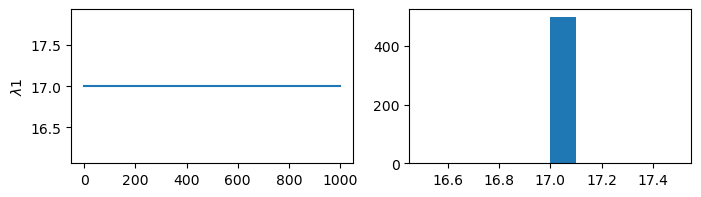

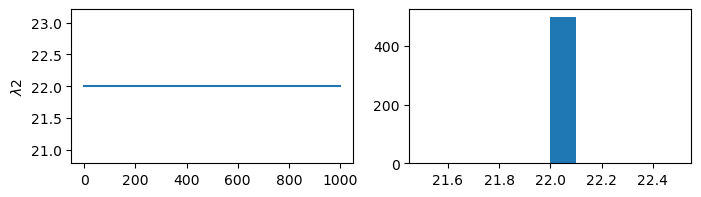

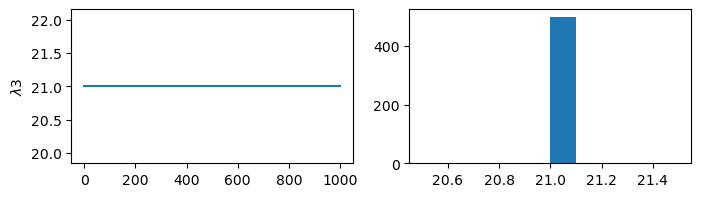

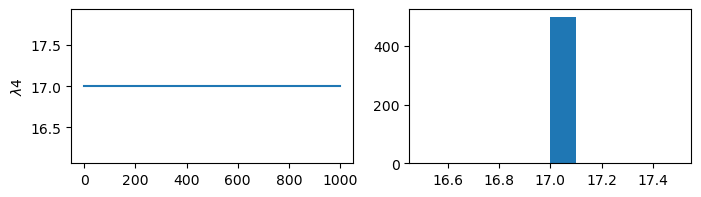

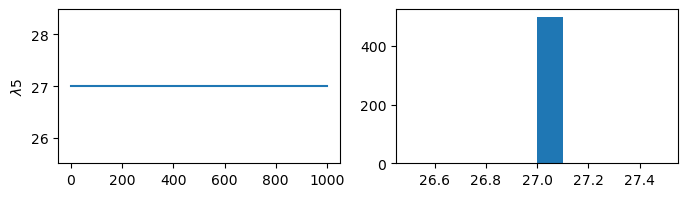

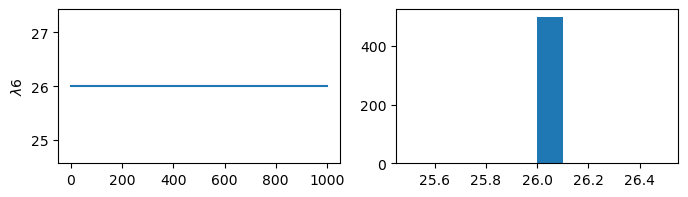

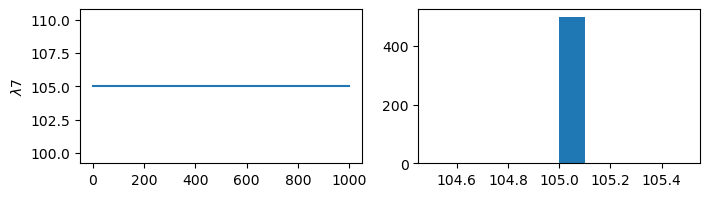

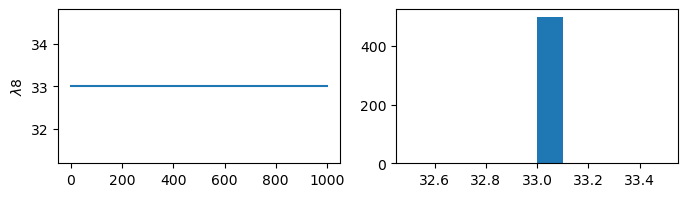

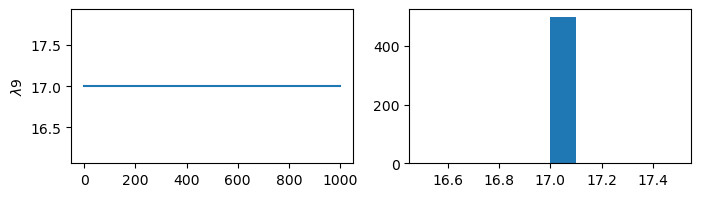

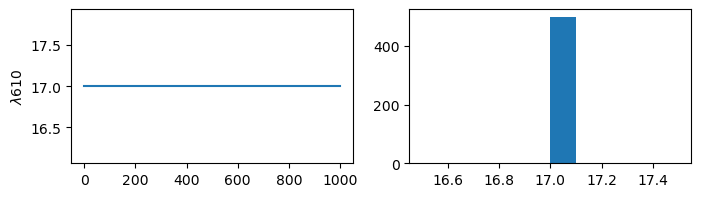

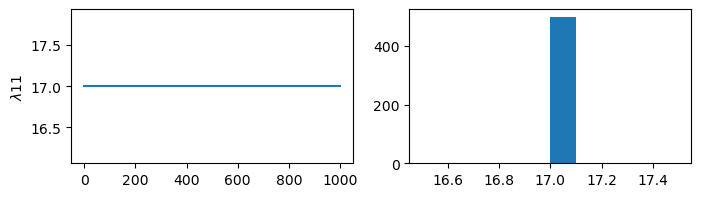

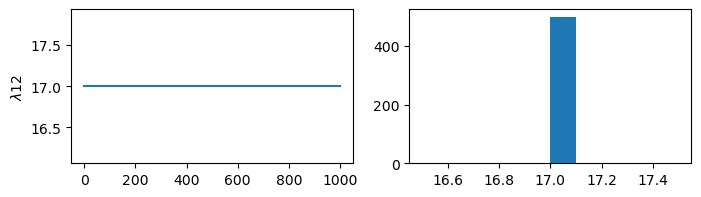

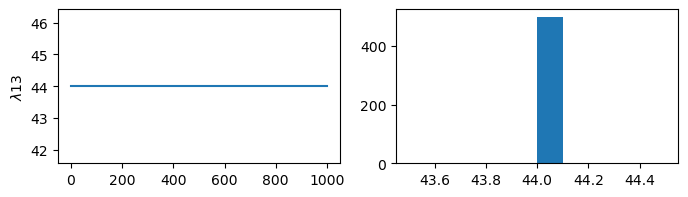

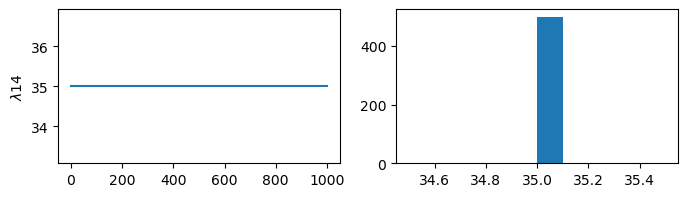

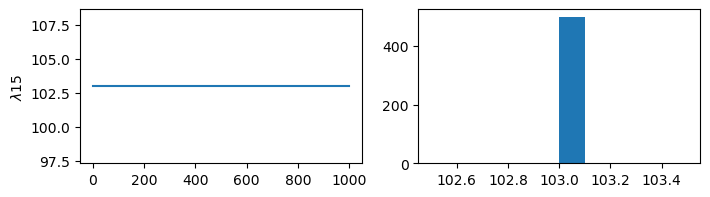

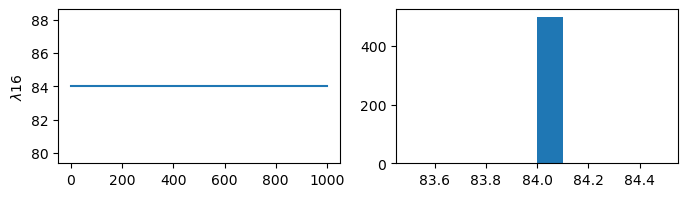

In [61]:
time_slice=3
lams=trace_tuned[:,:,time_slice]
#lams=trace_tuned
lam_labels=["$\lambda1$", "$\lambda2$", "$\lambda3$","$\lambda4$","$\lambda5$","$\lambda6$",
            "$\lambda7$","$\lambda8$","$\lambda9$","$\lambda610$","$\lambda11$","$\lambda12$",
            "$\lambda13$","$\lambda14$","$\lambda15$","$\lambda16$"]
for param, samples in zip(lam_labels, lams.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(len(samples)/2):])

### Helper function to calculate autocorrelation of each lambda trace

In [62]:
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

### This assigns the wrong color to each line

In [63]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

# Plot the lamdba trace autocorrelation
- Some time slices are more correlated than others
    - a_b : a is the coefficient (Lambda) and b is the time slice
- These got "stuck" or optimized earlier
- This will not plot if the output is constant (tuned model)

c:\Users\jkhac\anaconda3\envs\final_proj_torch\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


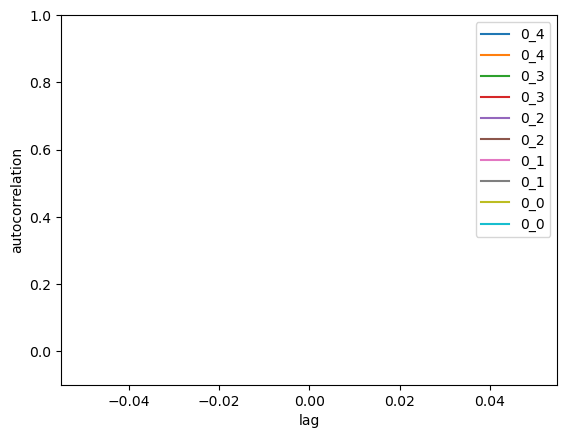

In [64]:
lags = np.arange(1, 100)
fig, ax = plt.subplots()
coeff=0
ax.plot(lags, [autocorr(trace_tuned[:,coeff,4], l)[:,0] for l in lags], label=str(coeff)+'_4')
ax.plot(lags, [autocorr(trace_tuned[:,coeff,3], l)[:,0] for l in lags], label=str(coeff)+'_3')
ax.plot(lags, [autocorr(trace_tuned[:,coeff,2], l)[:,0] for l in lags], label=str(coeff)+'_2')
ax.plot(lags, [autocorr(trace_tuned[:,coeff,1], l)[:,0] for l in lags], label=str(coeff)+'_1')
ax.plot(lags, [autocorr(trace_tuned[:,coeff,0], l)[:,0] for l in lags], label=str(coeff)+'_0')

#ax.plot(lags, [autocorr(trace_tuned[:,coeff], l)[:,0] for l in lags], label=str(coeff)+'_4')
#ax.plot(lags, [autocorr(trace_tuned[:,coeff], l)[:,0] for l in lags], label=str(coeff)+'_3')
#ax.plot(lags, [autocorr(trace_tuned[:,coeff], l)[:,0] for l in lags], label=str(coeff)+'_2')
#ax.plot(lags, [autocorr(trace_tuned[:,coeff], l)[:,0] for l in lags], label=str(coeff)+'_1')
#ax.plot(lags, [autocorr(trace_tuned[:,coeff], l)[:,0] for l in lags], label=str(coeff)+'_0')
ax.legend()
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

In [65]:
#np.mean(trace_tuned,axis=0)
np.mean(lams,axis=0)

array([ 17.,  22.,  21.,  17.,  27.,  26., 105.,  33.,  17.,  17.,  17.,
        17.,  44.,  35., 103.,  84.])

# Mean flow values on the routes to compare with (ECOS_BB in cvxpy)
[ 16.   21.6  15.   14.4   7.6  30.  158.2  34.6  12.4  21.    9.2  30.2
  52.   49.2 100.4  77.2]

In [66]:
x_flows=np.mean(trace_tuned,axis=0)
#np.mean(x_flows,axis=1)

print(f"{np.array2string(np.mean(x_flows,axis=1),precision=1, floatmode='fixed')}")
print(f"{np.array2string(np.std(x_flows,axis=1),precision=1, floatmode='fixed')}")
print(np.sum(np.mean(x_flows,axis=1)))

[ 17.0  22.8  21.8  17.0  19.4  28.2 141.4  30.4  17.0  18.8  17.0  20.0
  46.0  44.6 101.8  76.8]
[ 0.0  3.0  5.2  0.0  3.9 11.2 27.8  7.6  0.0  2.4  0.0  4.0  4.5  9.7
  9.5 13.5]
640.0197802197803


In [67]:
y_mcmc= aij @ x_flows

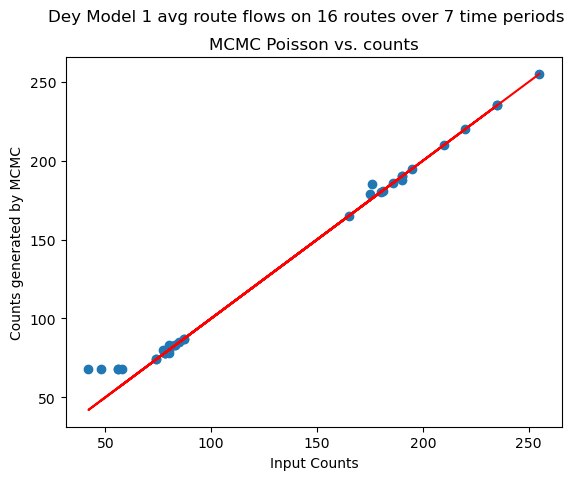

In [68]:

plt.scatter(counts,y_mcmc)
plt.plot(counts,counts,color="red")
plt.suptitle("Dey Model 1 avg route flows on 16 routes over 7 time periods")
plt.title("MCMC Poisson vs. counts")
plt.ylabel("Counts generated by MCMC")
plt.xlabel("Input Counts")
plt.savefig(path+"/MCMC_Model1DeyEtAl_counts")

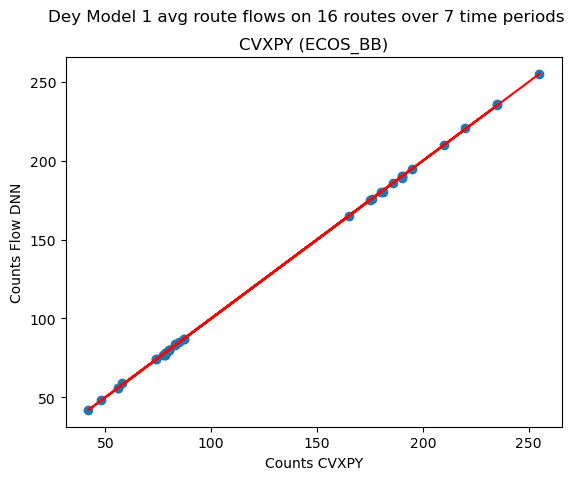

In [69]:
plt.scatter(counts,aij@x.value)
plt.plot(counts,counts,color="red")
plt.suptitle("Dey Model 1 avg route flows on 16 routes over 7 time periods")
plt.title("CVXPY (ECOS_BB)")
plt.ylabel("Counts Flow DNN")
plt.xlabel("Counts CVXPY")
plt.savefig(path+"/CVXPY_Model1DeyEtAl_counts")

In [70]:
x_flows

array([[ 17.        ,  17.        ,  17.        ,  17.        ,
         17.        ],
       [ 26.        ,  22.        ,  26.        ,  22.        ,
         18.        ],
       [ 18.        ,  32.        ,  18.        ,  21.        ,
         20.        ],
       [ 17.        ,  17.        ,  17.        ,  17.        ,
         17.        ],
       [ 17.        ,  17.        ,  19.        ,  27.        ,
         17.        ],
       [ 48.97302697,  19.        ,  29.        ,  26.        ,
         18.        ],
       [178.        , 117.        , 141.        , 105.        ,
        166.        ],
       [ 18.03896104,  27.        ,  33.        ,  33.        ,
         41.        ],
       [ 17.        ,  17.        ,  17.        ,  17.        ,
         17.        ],
       [ 17.        ,  17.        ,  23.        ,  17.        ,
         20.        ],
       [ 17.        ,  17.        ,  17.        ,  17.        ,
         17.        ],
       [ 18.02197802,  18.04195804,  19.   

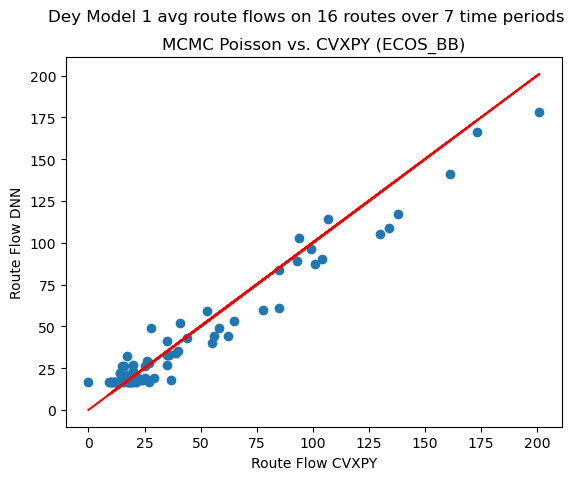

In [71]:
plt.scatter(x.value, x_flows)
plt.plot(x.value, x.value, "-", color="red")
plt.suptitle("Dey Model 1 avg route flows on 16 routes over 7 time periods")
plt.title("MCMC Poisson vs. CVXPY (ECOS_BB)")
plt.ylabel("Route Flow DNN")
plt.xlabel("Route Flow CVXPY")
plt.savefig(path+"/MCMC_Model1DeyEtAl_vs_CVXPY_route_flow")

In [72]:
od_flow_matrix_mcmc=od_flow_from_route_flow(od_pairs,x_flows)
print(od_flow_matrix_mcmc)

0 0 ('A', 'F', '0') [17. 17. 17. 17. 17.] [17. 17. 17. 17. 17.]
0 1 ('A', 'F', '1') [43. 39. 43. 39. 35.] [26. 22. 26. 22. 18.]
0 2 ('A', 'F', '2') [61. 71. 61. 60. 55.] [18. 32. 18. 21. 20.]
1 3 ('A', 'C', '0') [17. 17. 17. 17. 17.] [17. 17. 17. 17. 17.]
2 4 ('A', 'E', '0') [17. 17. 19. 27. 17.] [17. 17. 19. 27. 17.]
2 5 ('A', 'E', '1') [65.97302697 36.         48.         53.         35.        ] [48.97302697 19.         29.         26.         18.        ]
3 6 ('A', 'B', '0') [178. 117. 141. 105. 166.] [178. 117. 141. 105. 166.]
4 7 ('A', 'D', '0') [18.03896104 27.         33.         33.         41.        ] [18.03896104 27.         33.         33.         41.        ]
5 8 ('B', 'F', '0') [17. 17. 17. 17. 17.] [17. 17. 17. 17. 17.]
5 9 ('B', 'F', '1') [34. 34. 40. 34. 37.] [17. 17. 23. 17. 20.]
6 10 ('B', 'C', '0') [17. 17. 17. 17. 17.] [17. 17. 17. 17. 17.]
7 11 ('B', 'E', '0') [18.02197802 18.04195804 19.         17.         28.        ] [18.02197802 18.04195804 19.         17.  

### Plot the od flows and compare
- Plot is OD flow on y and time on x

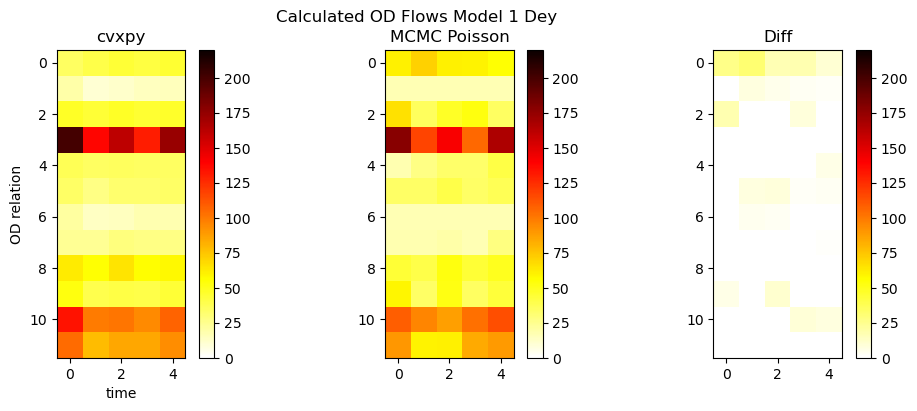

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
im1=axes[0].imshow(od_flow_matrix_x, cmap='hot_r', interpolation='nearest',vmin=0, vmax=220)
im2=axes[1].imshow(od_flow_matrix_mcmc, cmap='hot_r', interpolation='nearest',vmin=0, vmax=220)
im3=axes[2].imshow(od_flow_matrix_mcmc-od_flow_matrix_x, cmap='hot_r', interpolation='nearest',vmin=0, vmax=220)

axes[0].title.set_text('cvxpy')
axes[0].set_ylabel("OD relation")
axes[0].set_xlabel("time")
axes[1].title.set_text("MCMC Poisson")
axes[2].title.set_text("Diff")

plt.suptitle("Calculated OD Flows Model 1 Dey")
plt.colorbar(im1)
plt.colorbar(im2)
plt.colorbar(im3)
plt.savefig(path+"/MCMC_Model1DeyEtAl_vs_CVXPY_od_flow_heatmap")
plt.show()


In [74]:
print("The flows on each edge (one edge per row) in the 5 time slices (one time slice per column")
print("NOTE that all flows equal counts and that edge 2 flows have been imputed by the algorithm")
np.dot(a2ij,x_flows)

The flows on each edge (one edge per row) in the 5 time slices (one time slice per column
NOTE that all flows equal counts and that edge 2 flows have been imputed by the algorithm


array([[255.        , 190.        , 220.        , 188.        ,
        235.        ],
       [ 85.01198801,  78.        ,  80.        ,  80.        ,
         79.        ],
       [234.996004  , 181.        , 186.        , 185.        ,
        195.        ],
       [210.        , 165.        , 180.        , 179.        ,
        190.        ],
       [ 68.        ,  68.        ,  68.        ,  68.        ,
         68.        ],
       [ 78.02197802,  74.04195804,  87.        ,  83.        ,
         83.        ],
       [ 78.        ,  74.        ,  87.        ,  78.        ,
         83.        ]])

### 50 random regression lines drawn from the posterior

In [75]:
#plt.plot(age, price, 'bo')
#plt.xlabel('age (years)'); plt.ylabel('price ($1000\'s)')
#xvals = np.linspace(age.min(), age.max())
#for i in range(50):
#    b0,b1,tau = trace_tuned[np.random.randint(0, 1000)]
#    plt.plot(xvals, b0 + b1*xvals, 'r-', alpha=0.2)